# Sprint 11 Proyecto integrado 2

# Tabla de contenidos <a id='back'></a>

* [Descripción del proyecto](#Proyecto)
    * [Instrucciones](#Instrucciones)
    * [Introducción](#Introduccion)
    * [Diccionario de datos generales del proyecto (SQL)](#Diccionario)
* [Etapa 1. Descripción de los datos](#Descripcion)
    * [Inicialización](#Inicializacion)
* [Paso 2. Preprocesamiento de datos](#Preprocesamiento)
* [Paso 3. Análisis exploratorio de datos (EDA)](#Analisis)
    * [Estudio y Verificación de los Datos](#Verificación)
    * [Embudo de eventos](#eventos)
    * [Estudio de los resultados del experimento](#resultados)
* [Paso 4. Conclusión](#Conclusión)

# Descripción del proyecto<a id='Proyecto'></a>

# Introducción<a id='Introduccion'></a>

Este proyecto tiene como objetivo investigar el comportamiento de los usuarios en una aplicación de productos alimenticios, centrándose en el análisis del embudo de ventas y los resultados de un test A/A/B. El embudo de ventas nos permitirá comprender cómo los usuarios avanzan a lo largo de diferentes etapas hasta la compra final, identificando los puntos donde más usuarios abandonan el proceso. Además, el test A/A/B nos ayudará a evaluar el impacto de un cambio en las fuentes de la aplicación, comparando dos grupos de control con fuentes antiguas y un grupo de prueba con fuentes nuevas, con el fin de tomar decisiones basadas en datos sobre el diseño de la aplicación. Este análisis permitirá obtener insights clave para mejorar la conversión y la experiencia de usuario.

# Instrucciones<a id='Instrucciones'></a>

Trabajas en una empresa emergente que vende productos alimenticios. Debes investigar el comportamiento del usuario para la aplicación de la empresa.

Primero, estudia el embudo de ventas. Descubre cómo los usuarios y las usuarias llegan a la etapa de compra. ¿Cuántos usuarios o usuarias realmente llegan a esta etapa? ¿Cuántos se atascan en etapas anteriores? ¿Qué etapas en particular?

Luego, observa los resultados de un test A/A/B. (Sigue leyendo para obtener más información sobre los test A/A/B). Al equipo de diseño le gustaría cambiar las fuentes de toda la aplicación, pero la gerencia teme que los usuarios y las usuarias piensen que el nuevo diseño es intimidante. Por ello, deciden tomar una decisión basada en los resultados de un test A/A/B.

Los usuarios se dividen en tres grupos: dos grupos de control obtienen las fuentes antiguas y un grupo de prueba obtiene las nuevas. Descubre qué conjunto de fuentes produce mejores resultados.

Crear dos grupos A tiene ciertas ventajas. Podemos establecer el principio de que solo confiaremos en la exactitud de nuestras pruebas cuando los dos grupos de control sean similares. Si hay diferencias significativas entre los grupos A, esto puede ayudarnos a descubrir factores que pueden estar distorsionando los resultados. La comparación de grupos de control también nos dice cuánto tiempo y datos necesitaremos cuando realicemos más tests.

Utilizarás el mismo dataset para el análisis general y para el análisis A/A/B. En proyectos reales, los experimentos se llevan a cabo constantemente. El equipo de análisis estudia la calidad de una aplicación utilizando datos generales, sin prestar atención a si los usuarios y las usuarias participan en experimentos.

# Diccionario de datos<a id='Diccionario'></a>

* **EventName:** nombre del evento.
* **DeviceIDHash:** identificador de usuario unívoco.
* **EventTimestamp:** hora del evento.
* **ExpId:** número de experimento: 246 y 247 son los grupos de control, 248 es el grupo de prueba.

[Volver a Contenidos](#back)

# Descripción de los datos<a id='Descripcion'></a>
## Inicialización<a id='Inicializacion'></a>

In [1]:
#Se importan todas las librerias necesarias:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import ttest_ind
from scipy.stats import levene
import seaborn as sns
from datetime import datetime
from statsmodels.stats.proportion import proportions_ztest

In [2]:
#Se establece una paleta de colores para todos los gráficos del proyecto

sns.set_palette('pastel')

In [3]:
#Se cargan los datos

column_names = ['event_name', 'user_id', 'event_timestamp', 'exp_id']
logs_df = pd.read_csv('/datasets/logs_exp_us.csv', sep = '\t', names=column_names, header=0, dtype={'event_name': 'category'})

In [4]:
#Se muestra la información general de cada DataFrame

logs_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column           Non-Null Count   Dtype   
---  ------           --------------   -----   
 0   event_name       244126 non-null  category
 1   user_id          244126 non-null  int64   
 2   event_timestamp  244126 non-null  int64   
 3   exp_id           244126 non-null  int64   
dtypes: category(1), int64(3)
memory usage: 5.8 MB


In [5]:
#Se imprimen las primeras 5 lienas del DataFrame

logs_df.head()

,event_name,user_id,event_timestamp,exp_id
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


In [6]:
#Se calcula la cantidad de duplicados de cada DF

print('Duplicados en los datos del DataFrame:', logs_df.duplicated().sum())

Duplicados en los datos del DataFrame: 413


Durante la revisión inicial de los datos se determino un mejor nombre para las columnas del DataFrame, y se cambio el tipo de datos de la columna event_name a categorico, se mantiene el tipo entero en la columna exp_id para usos futuros; con el fin de mejorar la eficiencia en su manejo este es el nombre de cada columna:

* EventName - **event_name** (nombre del evento)
* DeviceIDHash - **user_id** (identificador de usuario unívoco)
* EventTimestamp - **event_time** (hora del evento)
* ExpId: número de experimento - **exp_id** (246 y 247 son los grupos de control, 248 es el grupo de prueba)

Con el fin de optimizar el manejo de los datos se determinaron ciertos cambios aplicables en la siguiente etapa:

* Abordar los datos duplicados del DataFrame.
* Cambiar el tipo de dato de la columna event_time al tipo fecha.

[Volver a Contenidos](#back)

## Preprocesamiento de datos<a id='Preprocesamiento'></a>

In [7]:
#Se verifica la información duplicada
#Se entiende que no hay un patrón en ninguna de las columnas de los datos duplicados, por lo que se decide eliminarlos.

print(logs_df[logs_df.duplicated()])

                     event_name              user_id  event_timestamp  exp_id
453            MainScreenAppear  5613408041324010552       1564474784     248
2350           CartScreenAppear  1694940645335807244       1564609899     248
3573           MainScreenAppear   434103746454591587       1564628377     248
4076           MainScreenAppear  3761373764179762633       1564631266     247
4803           MainScreenAppear  2835328739789306622       1564634641     248
...                         ...                  ...              ...     ...
242329         MainScreenAppear  8870358373313968633       1565206004     247
242332  PaymentScreenSuccessful  4718002964983105693       1565206005     247
242360  PaymentScreenSuccessful  2382591782303281935       1565206049     246
242362         CartScreenAppear  2382591782303281935       1565206049     246
242635         MainScreenAppear  4097782667445790512       1565206618     246

[413 rows x 4 columns]


In [8]:
#Se eliminan los datos duplicados

logs_df.drop_duplicates(inplace=True)

print('La cantidad de duplicados en los datos del DataFrame despues de la corrección es:', logs_df.duplicated().sum())

La cantidad de duplicados en los datos del DataFrame despues de la corrección es: 0


In [9]:
#Se convierte la columna event_time especificando que el formato de tiempo es en segundos.
#Se crea la columna time para contener la hora de cada evento
#Se crea la columna date para contener la fecha de cada evento

logs_df['event_timestamp'] = pd.to_datetime(logs_df['event_timestamp'], unit='s')
logs_df['time'] = logs_df['event_timestamp'].dt.time
logs_df['date'] = logs_df['event_timestamp'].dt.date

print(logs_df.head())

                event_name              user_id     event_timestamp  exp_id  \
0         MainScreenAppear  4575588528974610257 2019-07-25 04:43:36     246   
1         MainScreenAppear  7416695313311560658 2019-07-25 11:11:42     246   
2  PaymentScreenSuccessful  3518123091307005509 2019-07-25 11:28:47     248   
3         CartScreenAppear  3518123091307005509 2019-07-25 11:28:47     248   
4  PaymentScreenSuccessful  6217807653094995999 2019-07-25 11:48:42     248   

       time        date  
0  04:43:36  2019-07-25  
1  11:11:42  2019-07-25  
2  11:28:47  2019-07-25  
3  11:28:47  2019-07-25  
4  11:48:42  2019-07-25  


Luego de realizar las correcciones que se habían detectado, se ha confirmado que los tipos de datos de los DataFrames son adecuados y coherentes con la información contenida en las tablas. Esta validación asegura que los datos están correctamente estructurados y listos para ser utilizados en los análisis posteriores.

[Volver a Contenidos](#back)

## Análisis exploratorio de datos (EDA)<a id='Analisis'></a>

### Estudio y Verificación de los Datos<a id='Verificación'></a>

Luego de analizar el conjunto de datos, se identificó que los registros correspondientes al periodo entre el 25 y el 31 de julio de 2019 son insuficientes para llevar a cabo un análisis fiable. Por este motivo, se procedió a eliminar estos datos incompletos.

* El total de eventos eliminados fue de 2,826.
* El total de usuarios eliminados fue de 17.
* En total, se eliminaron 5 usuarios del grupo 246, 7 del grupo 247 y 5 del grupo 248. 

Se observa que los datos eliminados no representan una perdida significativa. Estos ajustes aseguran que los datos restantes sean más consistentes y adecuados para el análisis posterior.

In [10]:
#Se calcula el número total de eventos
total_events = logs_df.shape[0]

#Se calcula el número total de usuarios
total_users = logs_df['user_id'].nunique()

#Se calcula el promedio de eventos por usuario
mean_events_users = total_events / total_users

#Se calcula la fecha mínima y máxima del DataFrame
min_date = logs_df['date'].min()
max_date = logs_df['date'].max()

In [11]:
print(f"""
Número total de eventos: {total_events}
Número total de usuarios: {total_users}
Promedio de eventos por usuario: {mean_events_users:.2f}
Fecha mínima del DataFrame: {min_date}
Fecha máxima del DataFrame: {max_date}
""")


Número total de eventos: 243713
Número total de usuarios: 7551
Promedio de eventos por usuario: 32.28
Fecha mínima del DataFrame: 2019-07-25
Fecha máxima del DataFrame: 2019-08-07



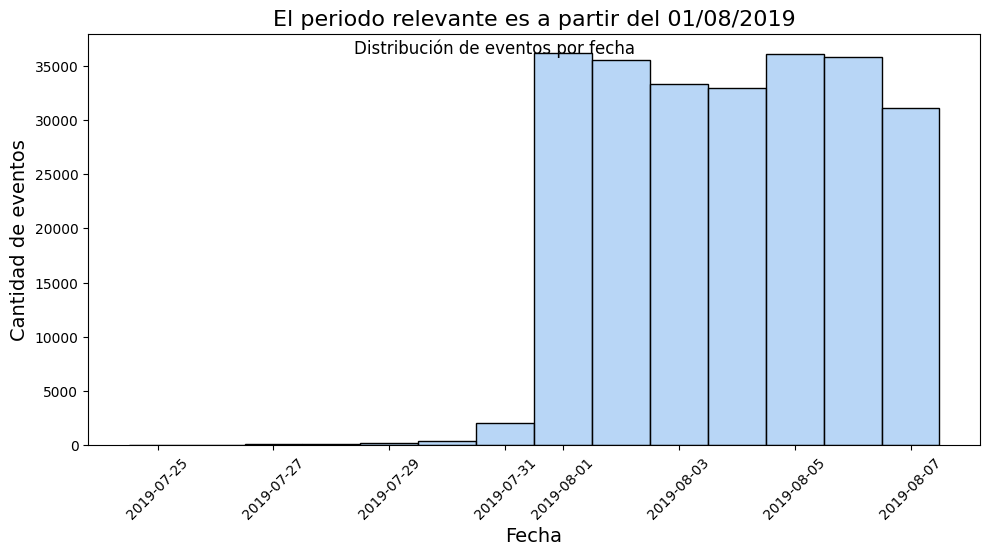

In [12]:
#Se representa gráficamente el histograma de eventos por fecha

plt.figure(figsize=(10,6))
sns.histplot(logs_df['date'], bins=50, kde=False)
plt.title('El periodo relevante es a partir del 01/08/2019', fontsize=16)
plt.suptitle('Distribución de eventos por fecha', fontsize=12, y=.87)
plt.xlabel('Fecha', fontsize=14)
plt.ylabel('Cantidad de eventos', fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [13]:
#Se filtra el DataFrame para incluir solo datos desde la fecha límite

limit_date = datetime.strptime('2019-08-01', '%Y-%m-%d').date()
filtered_logs = logs_df[logs_df['date'] >= limit_date]

In [14]:
#Se calcula el total de eventos luego de la limpieza
total_events_clean = filtered_logs.shape[0]

#Se calcula el total de usuarios luego de la limpieza
total_users_clean = filtered_logs['user_id'].nunique()

#Se calcula la fecha mínima y máxima del DataFrame despues de la limpieza
min_date_clean = filtered_logs['date'].min()
max_date_clean = filtered_logs['date'].max()

#Se calcula la cantidad de usuarios por grupo antes de la limpieza
users_per_group = logs_df.groupby('exp_id')['user_id'].nunique()

#Se calcula la cantidad de usuarios por grupo despues de la limpieza
users_per_group_clean = filtered_logs.groupby('exp_id')['user_id'].nunique()

In [15]:
print(f"""
Total de eventos eliminados con la limpieza: {total_events - total_events_clean}
Total de usuarios eliminados con la limpieza: {total_users - total_users_clean}
Fecha mínima del DataFrame despues de la limpieza: {min_date_clean}
Fecha máxima del DataFrame despues de la limpieza: {max_date_clean}
La cantidad de usuarios por grupo que se emilinaron es: {users_per_group - users_per_group_clean}
""")


Total de eventos eliminados con la limpieza: 2826
Total de usuarios eliminados con la limpieza: 17
Fecha mínima del DataFrame despues de la limpieza: 2019-08-01
Fecha máxima del DataFrame despues de la limpieza: 2019-08-07
La cantidad de usuarios por grupo que se emilinaron es: exp_id
246    5
247    7
248    5
Name: user_id, dtype: int64



[Volver a Contenidos](#back)

### Embudo de eventos<a id='eventos'></a>

Luego de analizar los datos, observamos que el evento más frecuente es **MainScreenAppear con 117,328 registros**, seguido de OffersScreenAppear y CartScreenAppear. Sin embargo, solo un **46.97% de los usuarios completaron todo el viaje** hasta PaymentScreenSuccessful. Se entiende que el tutorial es opcional y no forma parte del embudo, mientras que el orden del embudo es determinado por la cantidad de usuarios en cada paso.

El análisis de las proporciones muestra que:

* El **98.47%** de los usuarios accede a la pantalla principal (**MainScreenAppear**).
* Un **60.96%** continúa a la pantalla de ofertas (**OffersScreenAppear**).
* El **49.56%** llega a la pantalla del carrito (**CartScreenAppear**).
* Finalmente, un **46.97%** completa el proceso de pago exitoso (**PaymentScreenSuccessful**).

El embudo de conversión refleja que la **mayor pérdida de usuarios ocurre entre la pantalla principal y la de ofertas**, con un **61.91%** de usuarios pasando de una etapa a la otra. Sin embargo, la conversión entre las siguientes etapas mejora, alcanzando un **94.78% entre la pantalla del carrito y el pago exitoso**.

In [16]:
#Se calcula la cantidad de eventos registrados en el DataFrame

event_frequency = filtered_logs['event_name'].value_counts()
print('Cantidad de eventos registrados en el DataFrame:\n', event_frequency)

Cantidad de eventos registrados en el DataFrame:
 MainScreenAppear           117328
OffersScreenAppear          46333
CartScreenAppear            42303
PaymentScreenSuccessful     33918
Tutorial                     1005
Name: event_name, dtype: int64


In [17]:
#Se calcula la cantidad de usuarios por evento

users_per_event = filtered_logs.groupby('event_name')['user_id'].nunique().sort_values(ascending=False)
print('Cantidad de usuarios por evento:\n' ,users_per_event)

Cantidad de usuarios por evento:
 event_name
MainScreenAppear           7419
OffersScreenAppear         4593
CartScreenAppear           3734
PaymentScreenSuccessful    3539
Tutorial                    840
Name: user_id, dtype: int64


In [18]:
#Se calcula la proporción de usuarios que realizaron cada evento al menos una vez

proportion_per_event = (users_per_event / total_users_clean) * 100
print('Proporción de usuarios que realizaron cada evento al menos una vez:\n', proportion_per_event.round(2))

Proporción de usuarios que realizaron cada evento al menos una vez:
 event_name
MainScreenAppear           98.47
OffersScreenAppear         60.96
CartScreenAppear           49.56
PaymentScreenSuccessful    46.97
Tutorial                   11.15
Name: user_id, dtype: float64


In [19]:
#Se calcula la proporción de usuarios entre etapas

events_order = ['MainScreenAppear', 'OffersScreenAppear', 'CartScreenAppear', 'PaymentScreenSuccessful']
for i in range(1, len(events_order)):
    users_stage_current = filtered_logs[filtered_logs['event_name'] == events_order[i-1]]['user_id'].nunique()
    users_stage_next = filtered_logs[filtered_logs['event_name'] == events_order[i]]['user_id'].nunique()
    conversion_rate = (users_stage_next / users_stage_current) * 100
    print(f"Proporción de usuarios que pasan de {events_order[i-1]} a {events_order[i]}: {conversion_rate:.2f}%")

Proporción de usuarios que pasan de MainScreenAppear a OffersScreenAppear: 61.91%
Proporción de usuarios que pasan de OffersScreenAppear a CartScreenAppear: 81.30%
Proporción de usuarios que pasan de CartScreenAppear a PaymentScreenSuccessful: 94.78%


In [20]:
#Se calcula la proporción de usuarios que completan todo el viaje

total_completed_journey = filtered_logs[filtered_logs['event_name'] == 'PaymentScreenSuccessful']['user_id'].nunique()
journey_completion_rate = (total_completed_journey / total_users_clean) * 100
print(f"Porcentaje de usuarios que completan todo el viaje: {journey_completion_rate:.2f}%")

Porcentaje de usuarios que completan todo el viaje: 46.97%


[Volver a Contenidos](#back)

### Estudio de los resultados del experimento<a id='resultados'></a>

Luego de realizar un análisis detallado de los grupos de usuarios en los tests A/A (grupos 246 vs 247) y A/B (grupos 246 vs 248 y 247 vs 248). Se investigaron las proporciones de usuarios que realizaron diferentes eventos clave, aplicando tanto un nivel de significancia estándar como uno ajustado con la corrección de Bonferroni.

* **Test A/A (Grupos 246 y 247):** No se encontraron diferencias estadísticamente significativas en ninguna de las comparaciones entre los grupos de control, tanto a nivel de participación general como en los eventos individuales. Esto **confirma la correcta aleatorización de los grupos en el test**.

* **Test A/B (Grupos 246 vs 248 y 247 vs 248):** Las comparaciones entre los grupos de control y el grupo experimental no revelaron diferencias estadísticamente significativas en ninguno de los eventos analizados, incluso tras aplicar la corrección de Bonferroni. El ajuste del nivel de significancia no alteró estas conclusiones, sugiriendo que **las modificaciones probadas en el test no impactaron significativamente en el comportamiento de los usuarios**.

En resumen, tanto los tests A/A como A/B indicaron que no hubo diferencias significativas entre los grupos, lo que sugiere que los cambios introducidos no tuvieron un efecto claro sobre las métricas observadas.

**Usuarios de cada grupo**

In [21]:
print('Cantidad de usuarios que participaron en cada grupo:\n' ,users_per_group_clean)

Cantidad de usuarios que participaron en cada grupo:
 exp_id
246    2484
247    2513
248    2537
Name: user_id, dtype: int64


**Comparación de proporciones entre los grupos de control en el test A/A (246 y 247)**

In [22]:
#Se cuenta la cantidad de usuarios únicos en cada grupo
total_users_group_a = filtered_logs[filtered_logs['exp_id'] == 246]['user_id'].nunique()
total_users_group_b = filtered_logs[filtered_logs['exp_id'] == 247]['user_id'].nunique()

#Se aplica la prueba z para comparar proporciones entre los dos grupos
count_ab_proportion = [total_users_group_a, total_users_group_b]
nobs_ab_proportion = [total_users_group_a + total_users_group_b, total_users_group_a + total_users_group_b]

z_stat, p_value = proportions_ztest(count_ab_proportion, nobs_ab_proportion)

print(f"Estadístico z: {z_stat}")
print(f"Valor p: {p_value}")

if p_value < 0.05:
    print("Hay una diferencia estadísticamente significativa entre las proporciones de usuarios en los grupos 246 y 247.")
else:
    print("No hay una diferencia estadísticamente significativa entre las proporciones de usuarios en los grupos 246 y 247.")

Estadístico z: -0.5801740783391729
Valor p: 0.5617972322745155
No hay una diferencia estadísticamente significativa entre las proporciones de usuarios en los grupos 246 y 247.


**Análisis del evento más frecuente entre los grupos de control en el test A/A (246 vs 247)**

In [23]:
#Se encuentra el evento más popular

most_popular_event = filtered_logs['event_name'].value_counts().idxmax()
print(f"El evento más popular es: {most_popular_event}")

El evento más popular es: MainScreenAppear


In [24]:
#Se definen los grupos

group_a = 246
group_b = 247
group_c = 248

In [25]:
#Se encuentra la cantidad de usuarios que realizaron el evento más popular en cada grupo de control

#Se filtra el evento más popular para cada grupo
users_group_a_event = filtered_logs[(filtered_logs['exp_id'] == group_a) & 
                                    (filtered_logs['event_name'] == most_popular_event)]['user_id'].nunique()
users_group_b_event = filtered_logs[(filtered_logs['exp_id'] == group_b) & 
                                    (filtered_logs['event_name'] == most_popular_event)]['user_id'].nunique()

#Se calcula la proporción de usuarios en cada grupo que realizaron el evento más popular
proportion_group_a_event = users_group_a_event / total_users_group_a
proportion_group_b_event = users_group_b_event / total_users_group_b

print(f"Proporción de usuarios del grupo {group_a} que realizaron el evento más popular: {proportion_group_a_event:.2%}")
print(f"Proporción de usuarios del grupo {group_b} que realizaron el evento más popular: {proportion_group_b_event:.2%}")

count_ab_popular = [users_group_a_event, users_group_b_event]
nobs_ab_popular = [total_users_group_a, total_users_group_b]

# Realizar la prueba z para dos proporciones
z_stat, p_value = proportions_ztest(count_ab_popular, nobs_ab_popular)

print(f"Estadístico z: {z_stat}")
print(f"Valor p: {p_value}")

if p_value < 0.05:
    print("Hay una diferencia estadísticamente significativa entre los grupos.")
else:
    print("No hay una diferencia estadísticamente significativa entre los grupos.")

Proporción de usuarios del grupo 246 que realizaron el evento más popular: 98.63%
Proporción de usuarios del grupo 247 que realizaron el evento más popular: 98.53%
Estadístico z: 0.3093441851418436
Valor p: 0.7570597232046099
No hay una diferencia estadísticamente significativa entre los grupos.


**Análisis comparativo de cada evento entre los grupos de control en el test A/A**

In [26]:
#Se define la función para encontrar la proporción de usuarios para cada evento
#Se define la función para encontrar si existe una diferencia estadísticamente significativa entre los grupos para cada evento

print('Análisis comparativo de cada evento entre los grupos de control en el test A/A')

def compare_events(filtered_logs, group_a, group_b):
    
    events = filtered_logs['event_name'].unique()

    for event in events:
        
        #Se cuentan los usuarios que realizaron el evento en cada grupo
        users_group_a_event = filtered_logs[(filtered_logs['exp_id'] == group_a) & 
                                            (filtered_logs['event_name'] == event)]['user_id'].nunique()
        users_group_b_event = filtered_logs[(filtered_logs['exp_id'] == group_b) & 
                                            (filtered_logs['event_name'] == event)]['user_id'].nunique()

        #Se calcula el total de usuarios en cada grupo
        total_users_group_a = filtered_logs[filtered_logs['exp_id'] == group_a]['user_id'].nunique()
        total_users_group_b = filtered_logs[filtered_logs['exp_id'] == group_b]['user_id'].nunique()

        #Se calculan las proporciones
        proportion_group_a_event = users_group_a_event / total_users_group_a
        proportion_group_b_event = users_group_b_event / total_users_group_b

        #Se aplica la prueba z para dos proporciones
        count_ab = [users_group_a_event, users_group_b_event]
        nobs_ab = [total_users_group_a, total_users_group_b]
        z_stat, p_value = proportions_ztest(count_ab, nobs_ab)

        # Resultados
        print(f"\nEvento: {event}")
        print(f"Proporción grupo {group_a}: {proportion_group_a_event:.2%}")
        print(f"Proporción grupo {group_b}: {proportion_group_b_event:.2%}")
        print(f"Estadístico z: {z_stat:.2f}, Valor p: {p_value:.4f}")

        if p_value < 0.05:
            print("Hay una diferencia estadísticamente significativa entre los grupos.")
        else:
            print("No hay una diferencia estadísticamente significativa entre los grupos.")

compare_events(filtered_logs, group_a, group_b)

Análisis comparativo de cada evento entre los grupos de control en el test A/A

Evento: Tutorial
Proporción grupo 246: 11.19%
Proporción grupo 247: 11.26%
Estadístico z: -0.08, Valor p: 0.9377
No hay una diferencia estadísticamente significativa entre los grupos.

Evento: MainScreenAppear
Proporción grupo 246: 98.63%
Proporción grupo 247: 98.53%
Estadístico z: 0.31, Valor p: 0.7571
No hay una diferencia estadísticamente significativa entre los grupos.

Evento: OffersScreenAppear
Proporción grupo 246: 62.08%
Proporción grupo 247: 60.49%
Estadístico z: 1.15, Valor p: 0.2481
No hay una diferencia estadísticamente significativa entre los grupos.

Evento: CartScreenAppear
Proporción grupo 246: 50.97%
Proporción grupo 247: 49.26%
Estadístico z: 1.20, Valor p: 0.2288
No hay una diferencia estadísticamente significativa entre los grupos.

Evento: PaymentScreenSuccessful
Proporción grupo 246: 48.31%
Proporción grupo 247: 46.08%
Estadístico z: 1.58, Valor p: 0.1146
No hay una diferencia estadíst

**Análisis comparativo de cada evento entre los grupos en el test A/B (246 y 248)**

In [27]:
#Se define la función para encontrar la proporción de usuarios para cada evento
#Se define la función para encontrar si existe una diferencia estadísticamente significativa entre los grupos para cada evento

print('Análisis comparativo de cada evento entre los grupos en el test A/B (246 y 248)')

def compare_events(filtered_logs, group_a, group_c):
    
    events = filtered_logs['event_name'].unique()

    for event in events:
        
        #Se cuentan los usuarios que realizaron el evento en cada grupo
        users_group_a_event = filtered_logs[(filtered_logs['exp_id'] == group_a) & 
                                            (filtered_logs['event_name'] == event)]['user_id'].nunique()
        users_group_c_event = filtered_logs[(filtered_logs['exp_id'] == group_c) & 
                                            (filtered_logs['event_name'] == event)]['user_id'].nunique()

        #Se calcula el total de usuarios en cada grupo
        total_users_group_a = filtered_logs[filtered_logs['exp_id'] == group_a]['user_id'].nunique()
        total_users_group_c = filtered_logs[filtered_logs['exp_id'] == group_c]['user_id'].nunique()

        #Se calculan las proporciones
        proportion_group_a_event = users_group_a_event / total_users_group_a
        proportion_group_c_event = users_group_c_event / total_users_group_c

        #Se aplica la prueba z para dos proporciones
        count_ac = [users_group_a_event, users_group_c_event]
        nobs_ac = [total_users_group_a, total_users_group_c]
        z_stat, p_value = proportions_ztest(count_ac, nobs_ac)

        # Resultados
        print(f"\nEvento: {event}")
        print(f"Proporción grupo {group_a}: {proportion_group_a_event:.2%}")
        print(f"Proporción grupo {group_c}: {proportion_group_c_event:.2%}")
        print(f"Estadístico z: {z_stat:.2f}, Valor p: {p_value:.4f}")

        if p_value < 0.05:
            print("Hay una diferencia estadísticamente significativa entre los grupos.")
        else:
            print("No hay una diferencia estadísticamente significativa entre los grupos.")

compare_events(filtered_logs, group_a, group_c)

Análisis comparativo de cada evento entre los grupos en el test A/B (246 y 248)

Evento: Tutorial
Proporción grupo 246: 11.19%
Proporción grupo 248: 11.00%
Estadístico z: 0.22, Valor p: 0.8264
No hay una diferencia estadísticamente significativa entre los grupos.

Evento: MainScreenAppear
Proporción grupo 246: 98.63%
Proporción grupo 248: 98.27%
Estadístico z: 1.05, Valor p: 0.2950
No hay una diferencia estadísticamente significativa entre los grupos.

Evento: OffersScreenAppear
Proporción grupo 246: 62.08%
Proporción grupo 248: 60.35%
Estadístico z: 1.26, Valor p: 0.2084
No hay una diferencia estadísticamente significativa entre los grupos.

Evento: CartScreenAppear
Proporción grupo 246: 50.97%
Proporción grupo 248: 48.48%
Estadístico z: 1.76, Valor p: 0.0784
No hay una diferencia estadísticamente significativa entre los grupos.

Evento: PaymentScreenSuccessful
Proporción grupo 246: 48.31%
Proporción grupo 248: 46.55%
Estadístico z: 1.25, Valor p: 0.2123
No hay una diferencia estadíst

**Análisis comparativo de cada evento entre los grupos en el test A/B (247 y 248)**

In [28]:
#Se define la función para encontrar la proporción de usuarios para cada evento
#Se define la función para encontrar si existe una diferencia estadísticamente significativa entre los grupos para cada evento

print('Análisis comparativo de cada evento entre los grupos en el test A/B (247 y 248)')

def compare_events(filtered_logs, group_b, group_c):
    
    events = filtered_logs['event_name'].unique()

    for event in events:
        #Se cuentan los usuarios que realizaron el evento en cada grupo
        users_group_b_event = filtered_logs[(filtered_logs['exp_id'] == group_b) & 
                                            (filtered_logs['event_name'] == event)]['user_id'].nunique()
        users_group_c_event = filtered_logs[(filtered_logs['exp_id'] == group_c) & 
                                            (filtered_logs['event_name'] == event)]['user_id'].nunique()

        #Se calcula el total de usuarios en cada grupo
        total_users_group_b = filtered_logs[filtered_logs['exp_id'] == group_b]['user_id'].nunique()
        total_users_group_c = filtered_logs[filtered_logs['exp_id'] == group_c]['user_id'].nunique()

        #Se calculan las proporciones
        proportion_group_b_event = users_group_b_event / total_users_group_b
        proportion_group_c_event = users_group_c_event / total_users_group_c

        #Se aplica la prueba z para dos proporciones
        count_bc = [users_group_b_event, users_group_c_event]
        nobs_bc = [total_users_group_b, total_users_group_c]
        z_stat, p_value = proportions_ztest(count_bc, nobs_bc)

        # Resultados
        print(f"\nEvento: {event}")
        print(f"Proporción grupo {group_b}: {proportion_group_b_event:.2%}")
        print(f"Proporción grupo {group_c}: {proportion_group_c_event:.2%}")
        print(f"Estadístico z: {z_stat:.2f}, Valor p: {p_value:.4f}")

        if p_value < 0.05:
            print("Hay una diferencia estadísticamente significativa entre los grupos.")
        else:
            print("No hay una diferencia estadísticamente significativa entre los grupos.")

compare_events(filtered_logs, group_b, group_c)

Análisis comparativo de cada evento entre los grupos en el test A/B (247 y 248)

Evento: Tutorial
Proporción grupo 247: 11.26%
Proporción grupo 248: 11.00%
Estadístico z: 0.30, Valor p: 0.7653
No hay una diferencia estadísticamente significativa entre los grupos.

Evento: MainScreenAppear
Proporción grupo 247: 98.53%
Proporción grupo 248: 98.27%
Estadístico z: 0.74, Valor p: 0.4587
No hay una diferencia estadísticamente significativa entre los grupos.

Evento: OffersScreenAppear
Proporción grupo 247: 60.49%
Proporción grupo 248: 60.35%
Estadístico z: 0.10, Valor p: 0.9198
No hay una diferencia estadísticamente significativa entre los grupos.

Evento: CartScreenAppear
Proporción grupo 247: 49.26%
Proporción grupo 248: 48.48%
Estadístico z: 0.56, Valor p: 0.5786
No hay una diferencia estadísticamente significativa entre los grupos.

Evento: PaymentScreenSuccessful
Proporción grupo 247: 46.08%
Proporción grupo 248: 46.55%
Estadístico z: -0.34, Valor p: 0.7373
No hay una diferencia estadís

**Corrección de Bonferroni**

In [29]:
#Se aplica el método de corrección 

#Se encuentra el número de eventos y comparaciones
num_events = len(filtered_logs['event_name'].unique())
num_comparisons = 3

#Se calcula el número de pruebas y nivel de significancia ajustado
num_tests = num_events * num_comparisons
alpha = 0.05
alpha_adjusted = alpha / num_tests

print(f"Nivel de significancia ajustado: {alpha_adjusted}")

Nivel de significancia ajustado: 0.0033333333333333335


**Aplicación del nuevo nivel de significancia (alpha) en el test A/A (246 y 247)**

In [30]:
#Se define la función para encontrar la proporción de usuarios para cada evento con el nivel de significancia ajustado
#Se define la función para encontrar si existe una diferencia estadísticamente significativa entre los grupos para cada evento con el nivel de significancia ajustado

print('Aplicación del nuevo nivel de significancia (alpha) en el test A/A (246 y 247)')

def compare_events(filtered_logs, group_a, group_b):
    
    events = filtered_logs['event_name'].unique()

    for event in events:
        #Se cuentan los usuarios que realizaron el evento en cada grupo
        users_group_a_event = filtered_logs[(filtered_logs['exp_id'] == group_a) & 
                                            (filtered_logs['event_name'] == event)]['user_id'].nunique()
        users_group_b_event = filtered_logs[(filtered_logs['exp_id'] == group_b) & 
                                            (filtered_logs['event_name'] == event)]['user_id'].nunique()

        #Se calcula el total de usuarios en cada grupo
        total_users_group_a = filtered_logs[filtered_logs['exp_id'] == group_a]['user_id'].nunique()
        total_users_group_b = filtered_logs[filtered_logs['exp_id'] == group_b]['user_id'].nunique()

        #Se aplica la prueba z para dos proporciones con el nivel de significancia ajustado
        count_ab_adjusted = [users_group_a_event, users_group_b_event]
        nobs_ab_adjusted = [total_users_group_a, total_users_group_b]
        z_stat, p_value = proportions_ztest(count_ab_adjusted, nobs_ab_adjusted)

        # Resultados
        print(f"\nEvento: {event}")
        print(f"Estadístico z: {z_stat:.2f}, Valor p: {p_value:.4f}")

        if p_value < alpha_adjusted:
            print("Hay una diferencia estadísticamente significativa entre los grupos con el nivel de significancia ajustado.")
        else:
            print("No hay una diferencia estadísticamente significativa entre los grupos con el nivel de significancia ajustado.")
            
compare_events(filtered_logs, group_a, group_b)

Aplicación del nuevo nivel de significancia (alpha) en el test A/A (246 y 247)

Evento: Tutorial
Estadístico z: -0.08, Valor p: 0.9377
No hay una diferencia estadísticamente significativa entre los grupos con el nivel de significancia ajustado.

Evento: MainScreenAppear
Estadístico z: 0.31, Valor p: 0.7571
No hay una diferencia estadísticamente significativa entre los grupos con el nivel de significancia ajustado.

Evento: OffersScreenAppear
Estadístico z: 1.15, Valor p: 0.2481
No hay una diferencia estadísticamente significativa entre los grupos con el nivel de significancia ajustado.

Evento: CartScreenAppear
Estadístico z: 1.20, Valor p: 0.2288
No hay una diferencia estadísticamente significativa entre los grupos con el nivel de significancia ajustado.

Evento: PaymentScreenSuccessful
Estadístico z: 1.58, Valor p: 0.1146
No hay una diferencia estadísticamente significativa entre los grupos con el nivel de significancia ajustado.


**Aplicación del nuevo nivel de significancia (alpha)  en el test A/B (246 y 248)**

In [31]:
#Se define la función para encontrar la proporción de usuarios para cada evento con el nivel de significancia ajustado
#Se define la función para encontrar si existe una diferencia estadísticamente significativa entre los grupos para cada evento con el nivel de significancia ajustado

print('Aplicación del nuevo nivel de significancia (alpha) en el test A/B (246 y 248)')

def compare_events(filtered_logs, group_a, group_c):
    
    events = filtered_logs['event_name'].unique()

    for event in events:
        #Se cuentan los usuarios que realizaron el evento en cada grupo
        users_group_a_event = filtered_logs[(filtered_logs['exp_id'] == group_a) & 
                                            (filtered_logs['event_name'] == event)]['user_id'].nunique()
        users_group_c_event = filtered_logs[(filtered_logs['exp_id'] == group_c) & 
                                            (filtered_logs['event_name'] == event)]['user_id'].nunique()

        #Se calcula el total de usuarios en cada grupo
        total_users_group_a = filtered_logs[filtered_logs['exp_id'] == group_a]['user_id'].nunique()
        total_users_group_c = filtered_logs[filtered_logs['exp_id'] == group_c]['user_id'].nunique()

        #Se aplica la prueba z para dos proporciones con el nivel de significancia ajustado
        count_ac_adjusted = [users_group_a_event, users_group_c_event]
        nobs_ac_adjusted = [total_users_group_a, total_users_group_c]
        z_stat, p_value = proportions_ztest(count_ac_adjusted, nobs_ac_adjusted)

        # Resultados
        print(f"\nEvento: {event}")
        print(f"Estadístico z: {z_stat:.2f}, Valor p: {p_value:.4f}")

        if p_value < alpha_adjusted:
            print("Hay una diferencia estadísticamente significativa entre los grupos con el nivel de significancia ajustado.")
        else:
            print("No hay una diferencia estadísticamente significativa entre los grupos con el nivel de significancia ajustado.")

compare_events(filtered_logs, group_a, group_c)

Aplicación del nuevo nivel de significancia (alpha) en el test A/B (246 y 248)

Evento: Tutorial
Estadístico z: 0.22, Valor p: 0.8264
No hay una diferencia estadísticamente significativa entre los grupos con el nivel de significancia ajustado.

Evento: MainScreenAppear
Estadístico z: 1.05, Valor p: 0.2950
No hay una diferencia estadísticamente significativa entre los grupos con el nivel de significancia ajustado.

Evento: OffersScreenAppear
Estadístico z: 1.26, Valor p: 0.2084
No hay una diferencia estadísticamente significativa entre los grupos con el nivel de significancia ajustado.

Evento: CartScreenAppear
Estadístico z: 1.76, Valor p: 0.0784
No hay una diferencia estadísticamente significativa entre los grupos con el nivel de significancia ajustado.

Evento: PaymentScreenSuccessful
Estadístico z: 1.25, Valor p: 0.2123
No hay una diferencia estadísticamente significativa entre los grupos con el nivel de significancia ajustado.


**Aplicación del nuevo nivel de significancia (alpha)  en el test A/B (247 y 248)**

In [32]:
#Se define la función para encontrar la proporción de usuarios para cada evento con el nivel de significancia ajustado
#Se define la función para encontrar si existe una diferencia estadísticamente significativa entre los grupos para cada evento con el nivel de significancia ajustado

print('Aplicación del nuevo nivel de significancia (alpha) en el test A/B (247 y 248)')

def compare_events(filtered_logs, group_b, group_c):
    
    events = filtered_logs['event_name'].unique()

    for event in events:
        #Se cuentan los usuarios que realizaron el evento en cada grupo
        users_group_b_event = filtered_logs[(filtered_logs['exp_id'] == group_b) & 
                                            (filtered_logs['event_name'] == event)]['user_id'].nunique()
        users_group_c_event = filtered_logs[(filtered_logs['exp_id'] == group_c) & 
                                            (filtered_logs['event_name'] == event)]['user_id'].nunique()

        #Se calcula el total de usuarios en cada grupo
        total_users_group_b = filtered_logs[filtered_logs['exp_id'] == group_b]['user_id'].nunique()
        total_users_group_c = filtered_logs[filtered_logs['exp_id'] == group_c]['user_id'].nunique()

        #Se aplica la prueba z para dos proporciones con el nivel de significancia ajustado
        count_bc_adjusted = [users_group_b_event, users_group_c_event]
        nobs_bc_adjusted = [total_users_group_b, total_users_group_c]
        z_stat, p_value = proportions_ztest(count_bc_adjusted, nobs_bc_adjusted)

        # Resultados
        print(f"\nEvento: {event}")
        print(f"Estadístico z: {z_stat:.2f}, Valor p: {p_value:.4f}")

        if p_value < alpha_adjusted:
            print("Hay una diferencia estadísticamente significativa entre los grupos con el nivel de significancia ajustado.")
        else:
            print("No hay una diferencia estadísticamente significativa entre los grupos con el nivel de significancia ajustado.")

compare_events(filtered_logs, group_b, group_c)

Aplicación del nuevo nivel de significancia (alpha) en el test A/B (247 y 248)

Evento: Tutorial
Estadístico z: 0.30, Valor p: 0.7653
No hay una diferencia estadísticamente significativa entre los grupos con el nivel de significancia ajustado.

Evento: MainScreenAppear
Estadístico z: 0.74, Valor p: 0.4587
No hay una diferencia estadísticamente significativa entre los grupos con el nivel de significancia ajustado.

Evento: OffersScreenAppear
Estadístico z: 0.10, Valor p: 0.9198
No hay una diferencia estadísticamente significativa entre los grupos con el nivel de significancia ajustado.

Evento: CartScreenAppear
Estadístico z: 0.56, Valor p: 0.5786
No hay una diferencia estadísticamente significativa entre los grupos con el nivel de significancia ajustado.

Evento: PaymentScreenSuccessful
Estadístico z: -0.34, Valor p: 0.7373
No hay una diferencia estadísticamente significativa entre los grupos con el nivel de significancia ajustado.


[Volver a Contenidos](#back)

## Conclusión<a id='Conclusion'></a>

En este proyecto, se investigó el **comportamiento de los usuarios** en una aplicación de una empresa emergente que vende productos alimenticios, centrándonos en dos aspectos principales: **el análisis del embudo de ventas y los resultados de un test A/A/B**.

* Inicialmente, **se optimizó el dataset** ajustando los nombres de las columnas, eliminando duplicados y transformando el tipo de datos de ciertas columnas para facilitar su análisis. Se descartaron datos incompletos, lo que permitió trabajar con un conjunto más fiable.


* El **embudo de ventas** mostró que, aunque la mayoría de los usuarios accedían a la pantalla principal, el 60.96% continuaba a la pantalla de ofertas, y solo un 46.97% completaba el proceso de compra. El análisis de las conversiones reveló que la mayor pérdida de usuarios ocurría en el paso de la pantalla principal a la de ofertas, con una mejor retención en las siguientes etapas del embudo.


* Finalmente, se analizaron los **resultados del test A/A/B** para evaluar el impacto de cambiar las fuentes en la aplicación. Los resultados del test A/A (entre los dos grupos de control) confirmaron que no había diferencias significativas, validando la aleatorización de los grupos. De manera similar, el test A/B no reveló diferencias estadísticamente significativas entre los grupos de control y el experimental, lo que sugiere que el cambio en las fuentes no afectó el comportamiento de los usuarios.

En resumen, el análisis del embudo de ventas destacó áreas clave de mejora en la conversión de usuarios, y los resultados del test A/A/B indicaron que **los cambios en el diseño no tuvieron un impacto significativo en el comportamiento del usuario**.

[Volver a Contenidos](#back)